In [3]:
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fz

from skfuzzy import control as ctrl

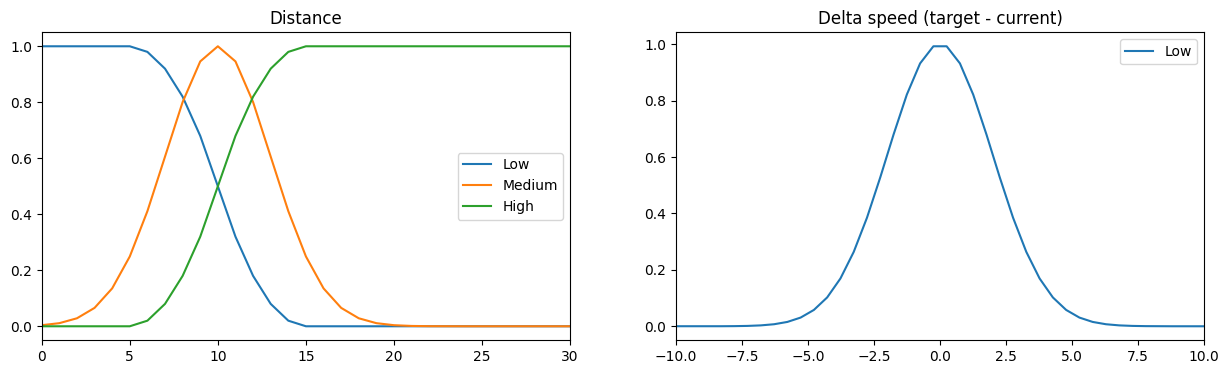

In [64]:
# TODO: use np.linspace instead of np.arange

# Variables
x_distance = np.arange(0, 1000, 1)
x_speed = np.linspace(-50, 50, 200)

x_throttle = np.arange(0, 1, 0.01)
x_brake = np.arange(0, 1, 0.01)

# Antecedents and consequents
distance = ctrl.Antecedent(x_distance, 'distance')
speed = ctrl.Antecedent(x_speed, 'speed')

throttle = ctrl.Consequent(x_throttle, 'throttle')
brake = ctrl.Consequent(x_brake, 'brake')

# Fuzzy membership functions
distance['low'] = distance_lo = fz.zmf(x_distance, 5, 15)
distance['medium'] = distance_md = fz.gaussmf(x_distance, 10, 3)
distance['high'] = distance_hi = fz.smf(x_distance, 5, 15)

speed['low'] = speed_lo = fz.gaussmf(x_speed, 0, 2)

fig, ax = plt.subplots(ncols=2, figsize=(15, 4))

ax[0].plot(x_distance, [fz.interp_membership(x_distance, distance_lo, x) for x in x_distance], label='Low')
ax[0].plot(x_distance, [fz.interp_membership(x_distance, distance_md, x) for x in x_distance], label='Medium')
ax[0].plot(x_distance, [fz.interp_membership(x_distance, distance_hi, x) for x in x_distance], label='High')
ax[0].set_xlim(0, 30)
ax[0].legend()
ax[0].set_title('Distance')

ax[1].plot(x_speed, [fz.interp_membership(x_speed, speed_lo, x) for x in x_speed], label='Low')
ax[1].set_xlim(-10, 10)
ax[1].legend()
ax[1].set_title('Delta speed (target - current)')

plt.show()

In [ ]:

x_distance = np.arange(0, 1_000, 1)
x_speed = np.arange(0, 1_000, 1)
x_target_speed = np.arange(0, 1_000, 1)

# Membership functions
dist_lo = fz.zmf(x_distance, 5, 15)
dist_hi = fz.smf(x_distance, 5, 15)
speed_hi = fz.smf(x_speed, 7, 9)

def throttle(distance, speed, limit):
    dst = fz.interp_membership(x_distance, dist_hi, distance)
    spd = fz.interp_membership(x_speed, speed_hi, limit - speed)

    return dst * spd

plt.figure(figsize=(20, 4))

plt.plot(x_distance, dist_lo, color='red', label='Distance low')
plt.plot(x_distance, dist_hi, color='orange', label='Distance high')
plt.plot(x_speed, speed_hi, color='blue', label='Speed high')

plt.xlim(0, 50)

r = [
    [100, 10, 30],
    [90, 12, 30],
    [80, 15, 30],
    [70, 20, 30],
    [60, 25, 30],
    [50, 30, 30],
    [40, 30, 30],
    [30, 30, 30],
    [20, 30, 30],
    [10, 30, 30],
    [0, 30, 30],
]

x = np.arange(0, len(r), 1)
y = [throttle(d, s, l) for d, s, l in r]

plt.plot(x, y, color='green', label='Throttle')

plt.legend()
plt.show()

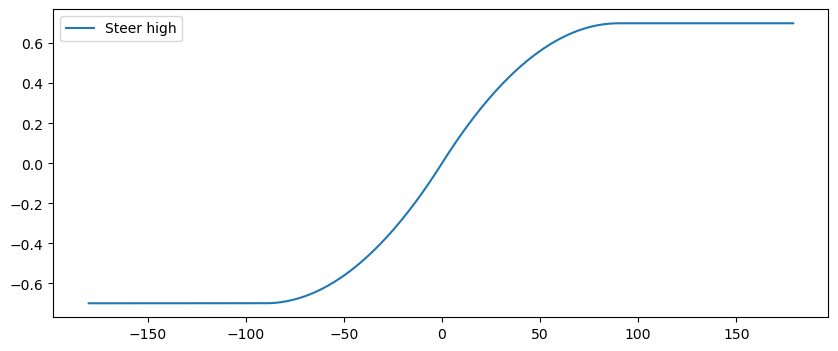

In [3]:
## Steering (based on angle and direction)
# Variables
x_steer = np.arange(-180, 180, 1)

# Membership functions
steer_hi = fz.smf(x_steer, -90, 90)

def steer(angle):
    steer = fz.interp_membership(x_steer, steer_hi, angle)

    steer = (steer - 0.5) * 2

    return 0.7 * steer

plt.figure(figsize=(10, 4))

x = x_steer
y = [steer(a) for a in x]

plt.plot(x, y, label='Steer high')

plt.legend()
plt.show()

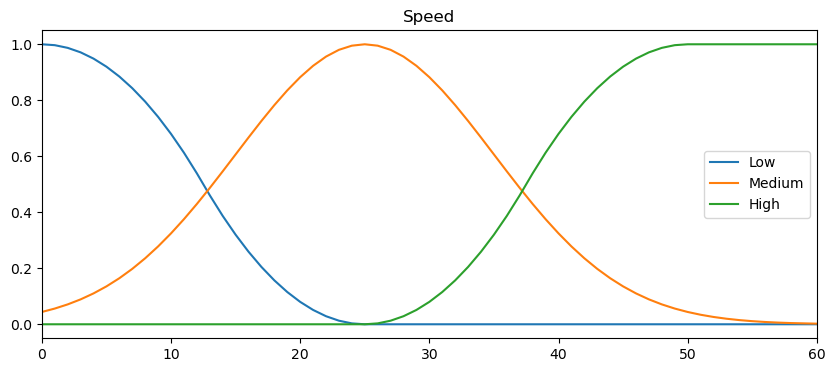

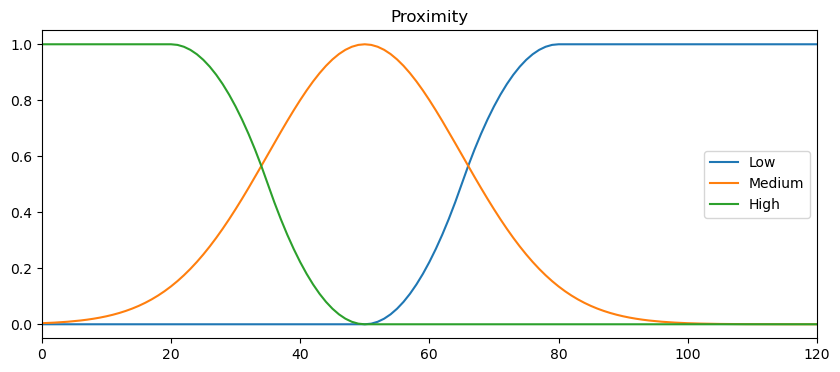

In [63]:
## Cruise (based on proximity and speed)
# Variables
x_proximity = np.arange(0, 1000, 1)
x_speed = np.arange(0, 1000, 1)

# Membership functions
speed_lo = fz.zmf(x_speed, 0, 25)
speed_md = fz.gaussmf(x_speed, 25, 10)
speed_hi = fz.smf(x_speed, 25, 50)

prox_lo = fz.smf(x_speed, 50, 80)
prox_md = fz.gaussmf(x_speed, 50, 15)
prox_hi = fz.zmf(x_speed, 20, 50)

# Plot membership functions
plt.figure(figsize=(10, 4))
plt.plot(x_speed, speed_lo, label='Low')
plt.plot(x_speed, speed_md, label='Medium')
plt.plot(x_speed, speed_hi, label='High')
plt.xlim(0, 60)
plt.legend()
plt.title('Speed')
plt.show()

plt.figure(figsize=(10, 4))
plt.plot(x_proximity, prox_lo, label='Low')
plt.plot(x_proximity, prox_md, label='Medium')
plt.plot(x_proximity, prox_hi, label='High')
plt.xlim(0, 120)
plt.legend()
plt.title('Proximity')
plt.show()
